# Easy Time Series Anomaly Detection 
# DEMO: Use of the framework

This notebook demonstrates the use of the __Easy Time Series Anomaly Detection__ framework.

The framework allows to use anomaly detectors from different libraries with a common interface.

Currently integrated libraries in the framework: 
* ADTK: https://adtk.readthedocs.io/en/stable/
* DARTS: https://unit8co.github.io/darts/
* RUPTURES: https://centre-borelli.github.io/ruptures-docs/




In [1]:

import sys
import pandas as pd


# Make the src directory visible  ---------
sys.path.append('../src')
#------------------------------------------


from base_anomaly_detector import read_yaml
import adtk_anomaly_detector as aad
import ruptures_change_point_detector as rcpd
import darts_forecasting_anomaly_detector as dfad




The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


### 1. Load the example data

In this example, we load an electrical time series (hourly energy) with ground truth labels.

Columns:
* timestamp
* value
* label


In [2]:
data_filename = '../data/energy_2021_2024_1hour.csv'
df = pd.read_csv(data_filename, parse_dates=['timestamp'], index_col='timestamp')
df

,value,label
timestamp,,
2021-01-01 00:00:00,3.086733,0
2021-01-01 01:00:00,2.919535,0
2021-01-01 02:00:00,2.855228,0
2021-01-01 03:00:00,2.688030,0
2021-01-01 04:00:00,2.546555,0
...,...,...
2024-06-30 19:00:00,4.936271,0
2024-06-30 20:00:00,5.101325,0
2024-06-30 21:00:00,5.112758,0


The same series will be used for train, validation and test. But different time intervals will be defined in the configuration 

In [3]:
train_val_data = df[['value']]
test_data = df[['value']]
known_anomalies_data = df[['label']]


## 2. Load the configuration

Load a configuration.  
The configuration in this case defines an anomaly detector using a DARTS regression forecaster.



In [4]:
config = read_yaml('../config/config_demo_use_of_the_framework.yaml')
config

{'darts': {'forecasting_model': {'class': 'SKLearnModel',
   'parameters': {'lags': 168,
    'lags_future_covariates': (168, 0),
    'lags_past_covariates': 168,
    'output_chunk_length': 1,
    'add_encoders': {'cyclic': {'past': ['hour', 'dayofweek'],
      'future': ['hour', 'dayofweek']}}}},
  'anomaly_scorer': {'class': 'WassersteinScorer',
   'parameters': {'window': 24, 'component_wise': False, 'window_agg': True}},
  'anomaly_detector': {'class': 'QuantileDetector',
   'parameters': {'high_quantile': 0.95}},
  'anomaly_model': {'class': 'ForecastingAnomalyModel',
   'fit_parameters': {'start': 0,
    'allow_model_training': False,
    'verbose': True}}},
 'adtk_detector': {'class': 'SeasonalAD',
  'parameters': {'freq': 24, 'c': 2, 'side': 'both', 'trend': False}},
 'ruptures_detector': {'class': 'BottomUp',
  'parameters': {'model': 'l1', 'min_size': 6, 'jump': 4}},
 'timestamps': {'train': {'start': '2021-01-01 00:00:00',
   'end': '2021-04-30 23:59:59',
   'freq': 'H'},
  '

In this case config file defines: 
* An algorithm from DARTS
* An algorithm from ADTK
* An algorithm from RUPTURES
* Time intervals for train, val and test
* The filename for logging


## Create detector for the first algorith (from DARTS)


In [5]:

detector = dfad.DartsForecastingAnomalyDetector(config, train_val_data, test_data, known_anomalies_data, "DARTS_Forecaster_AD")

Show all the datasets

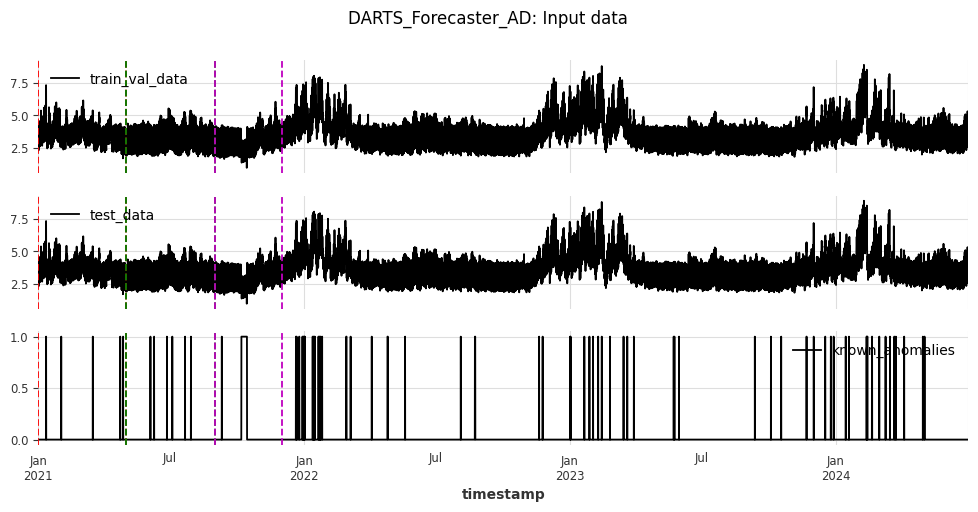

In [6]:
detector.plot_data(all_data=True)

Plot only the intervals defined in the configuration 

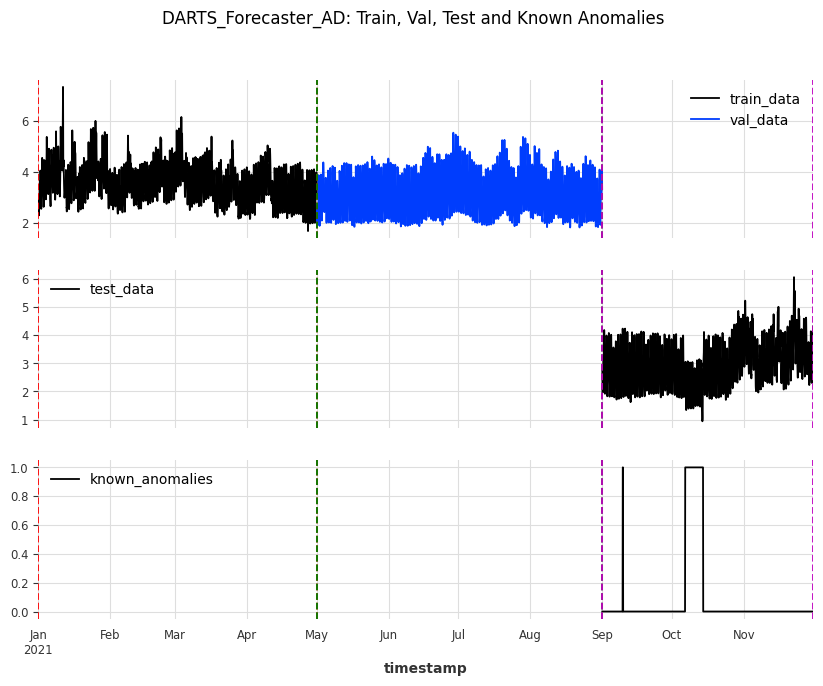

In [7]:
detector.plot_data(all_data=False)

## Training

In [8]:
detector.fit()

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

## Scores

Scores in the validation set

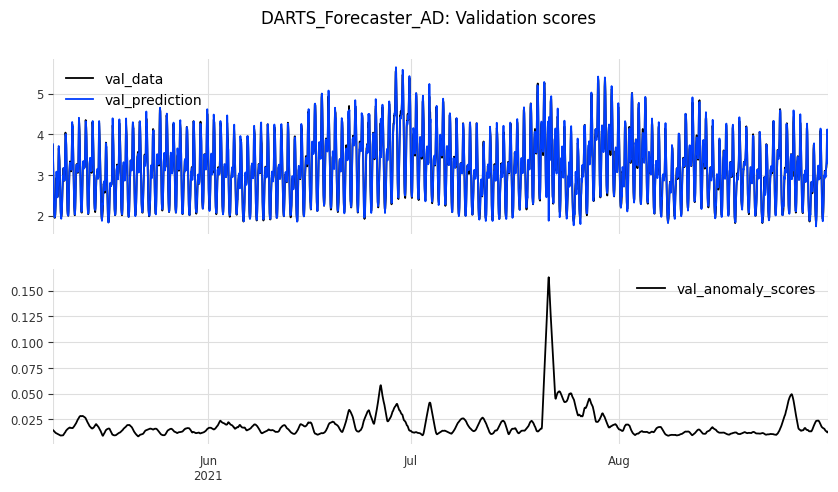

In [9]:
val_scores = detector.get_val_scores(plot=True)

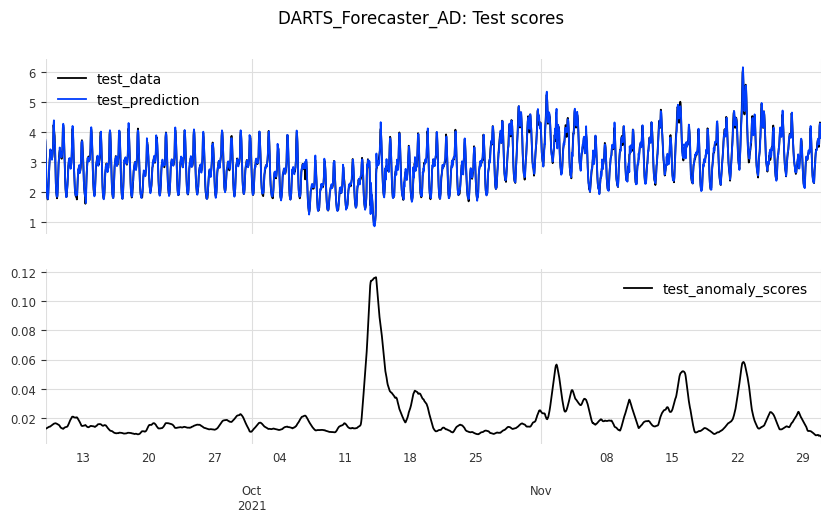

In [11]:
test_scores = detector.get_test_scores(plot=True)

Detect anomallies on the test set. 
Assuming that the train and val sets are "normal", we can set anomalies to the scores in test that are above the scores in val.

But val data is not clean in this case. We set here a threshold to the percentile 99 in test.

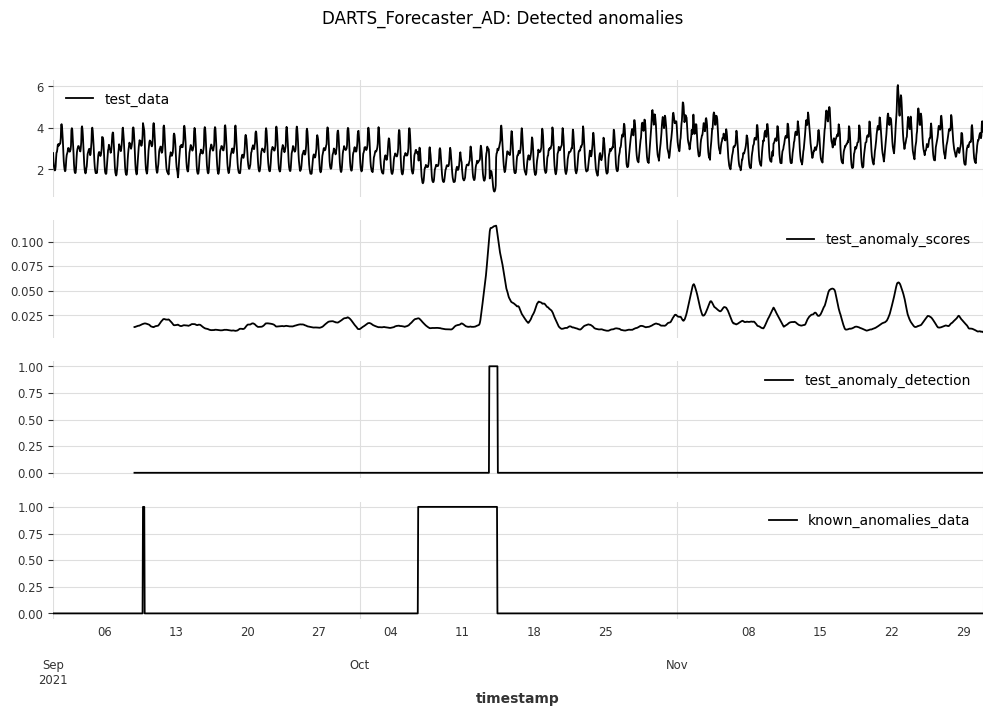

In [12]:
test_anomaly_detection = detector.get_test_anomaly_detection(plot=True, 
                                thresholding='test_percentile',
                                percentile=0.99,
                                recompute=False
                                )



## Detection with all the algorithms


In [13]:
detectors= [
    dfad.DartsForecastingAnomalyDetector(config, train_val_data, test_data, known_anomalies_data, "DARTS_Forecaster_AD"),
    aad.AdtkAnomalyDetector(config, train_val_data, test_data, known_anomalies_data, "ADTK_SeasonalAD"),
    rcpd.RupturesChangePointDetector(config, train_val_data, test_data, known_anomalies_data, "Ruptures_BottomUp")      
]

Code does not change !

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

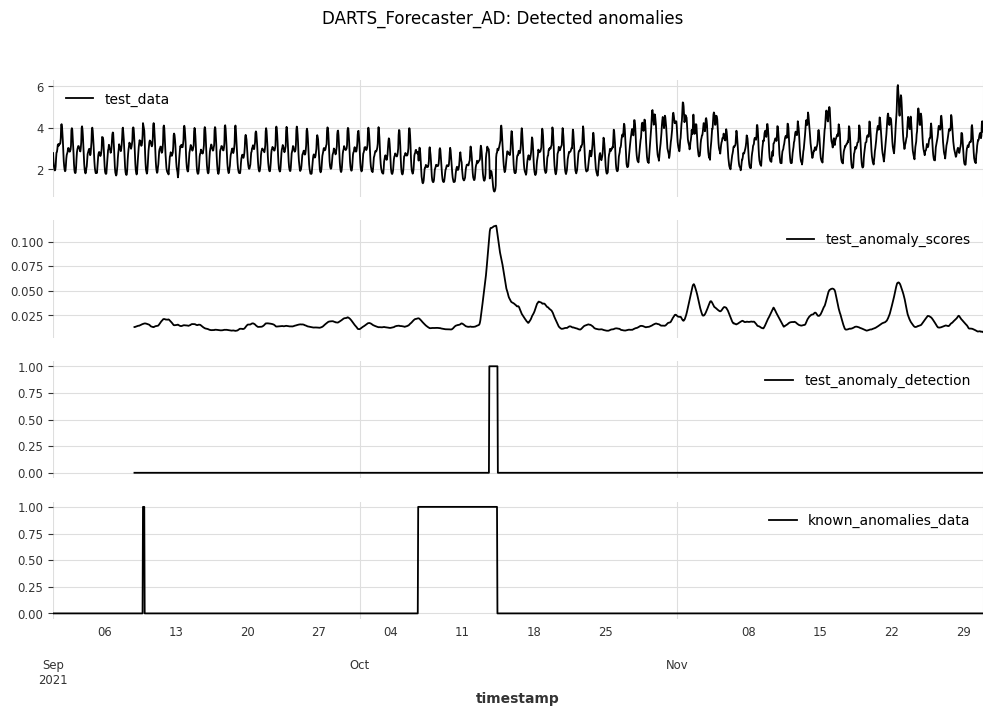

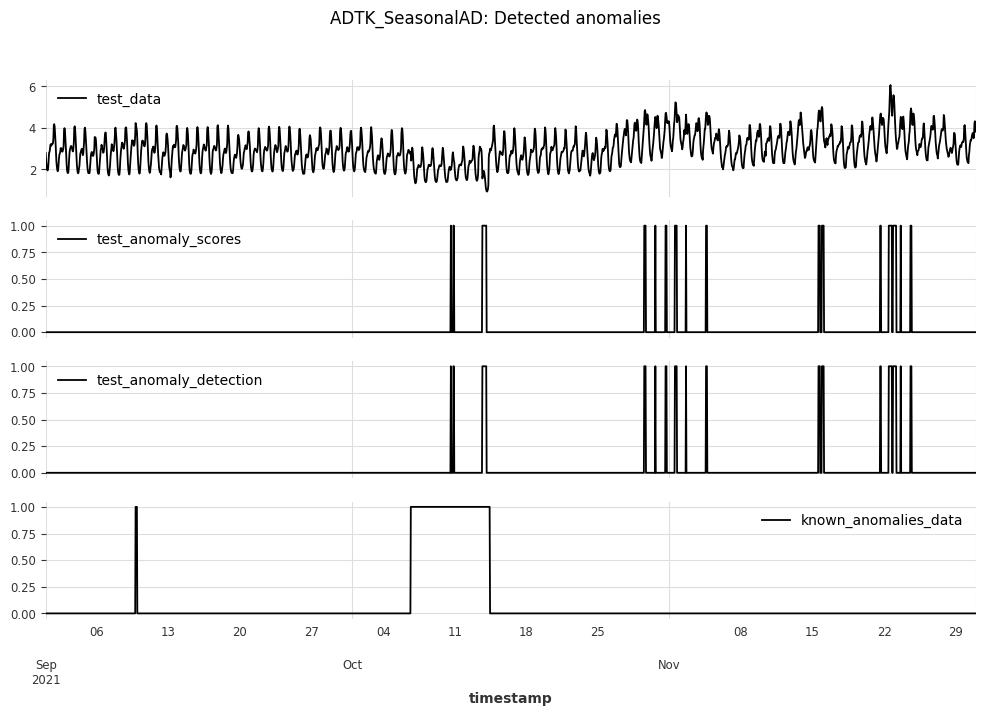

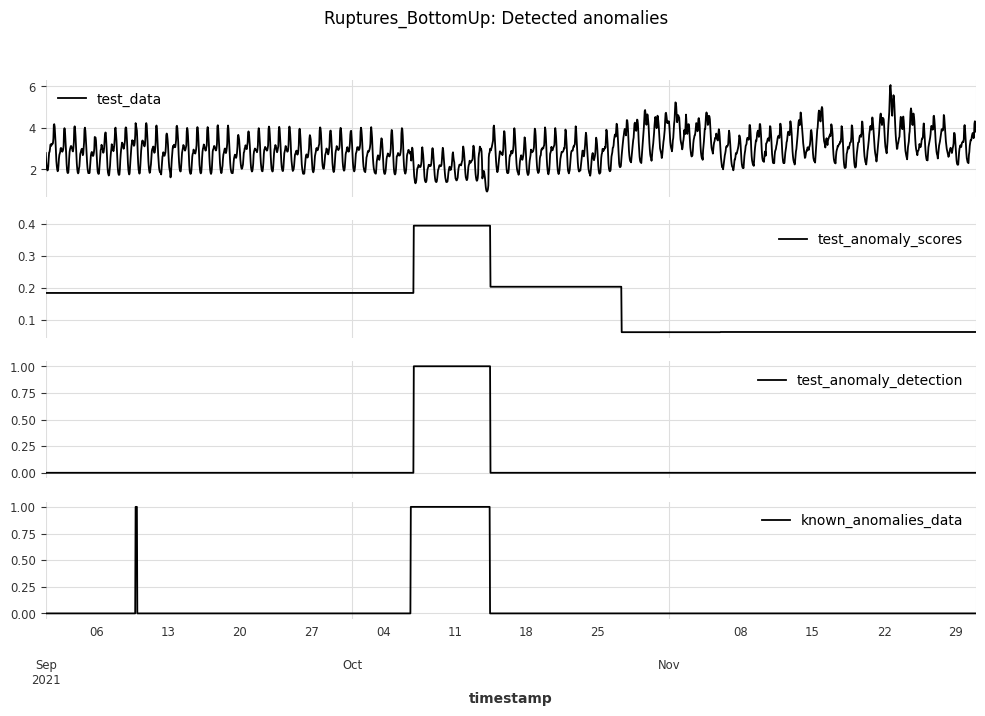

In [14]:
for detector in detectors:
    detector.fit() 
    detector.get_test_anomaly_detection(plot=True, 
                                thresholding='test_percentile',
                                percentile=0.99,
                                recompute=True
                                )

    

## Plots can also be done with plotly

In [15]:
detectors[0].plotting_backend = 'plotly'

In [16]:
detectors[0].plot_data(all_data=False)